<a href="https://colab.research.google.com/github/AndriiHomeniuk1/TinyVgg-with-Custom-Dataset/blob/main/TinyVgg_with_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import os
import zipfile
import requests
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from typing import Dict, List, Tuple
from timeit import default_timer as timer
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

In [2]:
# setting up device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [3]:
# loading dataset from kaggle

!kaggle datasets download -d sanikamal/horses-or-humans-dataset

Dataset URL: https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset
License(s): other
 97% 297M/307M [00:02<00:00, 140MB/s]
100% 307M/307M [00:02<00:00, 123MB/s]


In [4]:
# unzipping loaded dataset

with zipfile.ZipFile("/content/horses-or-humans-dataset.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall("data")

Unzipping data...


In [5]:
# remove extra folder

!rm -rf /content/data/horse-or-human/horse-or-human

In [6]:
# rename folder name from validation to test

!mv /content/data/horse-or-human/validation /content/data/horse-or-human/test

In [7]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir("/content/data")

There are 1 directories and 0 images in '/content/data'.
There are 2 directories and 0 images in '/content/data/horse-or-human'.
There are 2 directories and 0 images in '/content/data/horse-or-human/test'.
There are 0 directories and 128 images in '/content/data/horse-or-human/test/horses'.
There are 0 directories and 128 images in '/content/data/horse-or-human/test/humans'.
There are 2 directories and 0 images in '/content/data/horse-or-human/train'.
There are 0 directories and 500 images in '/content/data/horse-or-human/train/horses'.
There are 0 directories and 527 images in '/content/data/horse-or-human/train/humans'.


In [8]:
data_path = Path("data/")
image_path = data_path / "horse-or-human"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/horse-or-human/train'), PosixPath('data/horse-or-human/test'))

Custom dataset

In [72]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names

Target dir: data/horse-or-human/train


['horses', 'humans']

In [73]:
list(os.scandir(target_directory))


[<DirEntry 'horses'>, <DirEntry 'humans'>]

In [74]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [75]:
find_classes(target_directory)


(['horses', 'humans'], {'horses': 0, 'humans': 1})

Create a custom Dataset to replicate ImageFolder




In [207]:
#Write a custom dataset class
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.png"))  # Change format if need
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path).convert('RGB')  # Convert to RGB!!!

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [208]:
# Create a transform
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()
])

In [209]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [210]:
train_data_custom, test_data_custom


(<__main__.ImageFolderCustom at 0x7f54c7896a10>,
 <__main__.ImageFolderCustom at 0x7f54c7896980>)

In [211]:
len(train_data_custom)


1027

In [212]:
len(test_data_custom)

256

In [213]:
train_data_custom.classes


['horses', 'humans']

In [214]:
train_data_custom.class_to_idx


{'horses': 0, 'humans': 1}

In [293]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


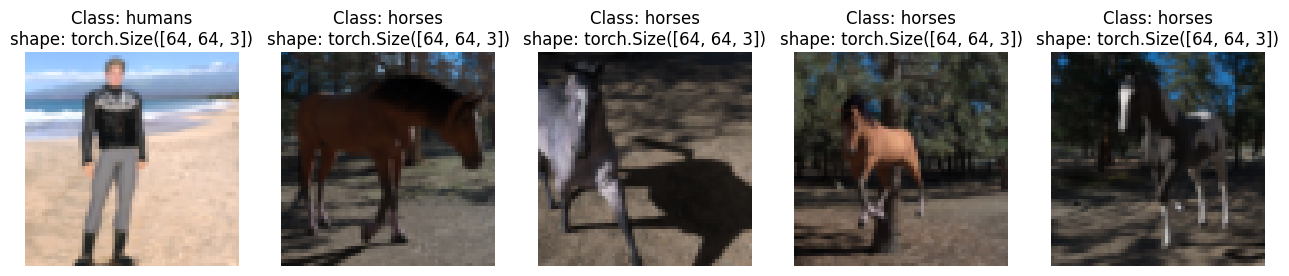

In [294]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [295]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f54c75d7610>,
 <torch.utils.data.dataloader.DataLoader at 0x7f54da233c10>)

In [296]:
# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

 Model TinyVGG

In [297]:
# Create simple transform
simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()
])

In [298]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

TinyVGG model class

In [299]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [300]:
model = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

In [301]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [302]:
# Try a forward pass
model(image_batch.to(device))

tensor([[-0.0139, -0.0202],
        [-0.0153, -0.0171],
        [-0.0233, -0.0233],
        [-0.0198, -0.0280],
        [-0.0143, -0.0215],
        [-0.0241, -0.0193],
        [-0.0221, -0.0244],
        [-0.0125, -0.0195],
        [-0.0158, -0.0229],
        [-0.0163, -0.0228],
        [-0.0173, -0.0210],
        [-0.0221, -0.0199],
        [-0.0152, -0.0209],
        [-0.0130, -0.0271],
        [-0.0176, -0.0222],
        [-0.0137, -0.0249],
        [-0.0133, -0.0214],
        [-0.0111, -0.0202],
        [-0.0122, -0.0231],
        [-0.0171, -0.0152],
        [-0.0141, -0.0217],
        [-0.0210, -0.0287],
        [-0.0117, -0.0225],
        [-0.0237, -0.0201],
        [-0.0224, -0.0231],
        [-0.0117, -0.0214],
        [-0.0200, -0.0214],
        [-0.0212, -0.0242],
        [-0.0219, -0.0256],
        [-0.0104, -0.0226],
        [-0.0209, -0.0206],
        [-0.0142, -0.0197]], grad_fn=<AddmmBackward0>)

In [303]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

Create train and test loops functions

In [304]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [305]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

function to combine train_step() and test_step()


In [306]:
# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

Train and evaluate model

In [307]:
# Set number of epochs
NUM_EPOCHS = 3

# Recreate an instance of TinyVGG
model = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_custom.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

# Start the timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.6656 | Train acc: 0.5619 | Test loss: 0.5791 | Test acc: 0.6758
Epoch: 1 | Train loss: 0.5596 | Train acc: 0.7169 | Test loss: 0.4156 | Test acc: 0.8320
Epoch: 2 | Train loss: 0.4771 | Train acc: 0.7652 | Test loss: 0.3709 | Test acc: 0.8711
Total training time: 32.470 seconds


In [308]:
model_results

{'train_loss': [0.6656010114785397, 0.5595586706291545, 0.47712247750975867],
 'train_acc': [0.5618686868686869, 0.7168560606060606, 0.7651515151515151],
 'test_loss': [0.5791332796216011, 0.41559974756091833, 0.37089019030099735],
 'test_acc': [0.67578125, 0.83203125, 0.87109375]}

loss curves

In [309]:
# Get the model_0_results keys
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [310]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

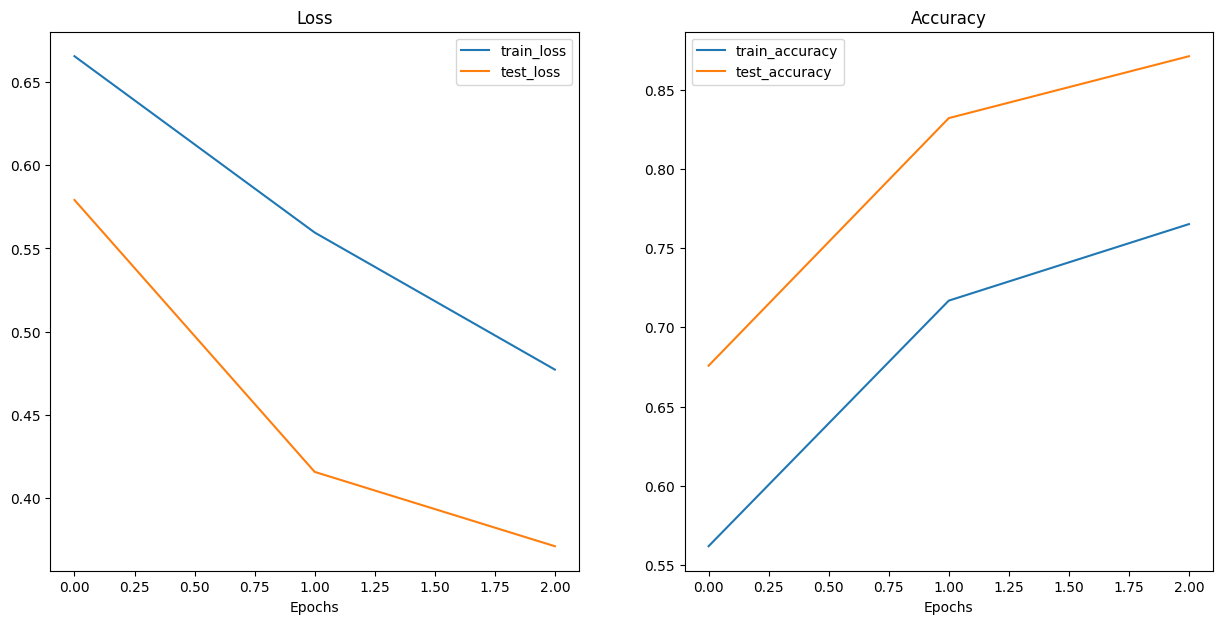

In [311]:
plot_loss_curves(model_results)


In [312]:
model_df = pd.DataFrame(model_results)
model_df

,train_loss,train_acc,test_loss,test_acc
0,0.665601,0.561869,0.579133,0.675781
1,0.559559,0.716856,0.415600,0.832031
2,0.477122,0.765152,0.370890,0.871094


Making a prediction on a custom image

In [313]:
download_link = 'https://hips.hearstapps.com/hmg-prod/images/james-bond-no-time-to-die-1572856101.jpg?resize=980:*'

response = requests.get(download_link)

if response.status_code == 200:
    file_data = response.content

    # Save the file to the desired location
    with open('downloaded_file.jpg', 'wb') as f:
        f.write(file_data)
        print('File downloaded successfully!')
else:
    print('Failed to download file. Status code:', response.status_code)

File downloaded successfully!


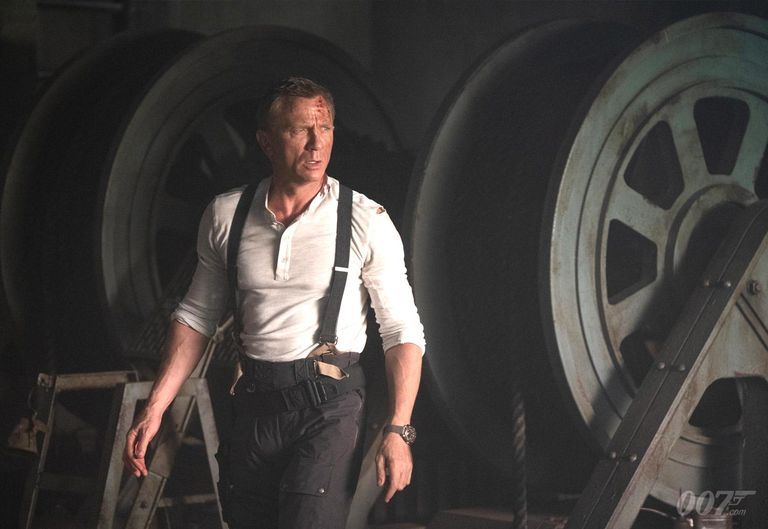

In [314]:
custom_image_path = "/content/downloaded_file.jpg"

open_custom_image = Image.open(custom_image_path)
open_custom_image

In [315]:
# Create simple transform
custom_image_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64))
])

In [316]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)



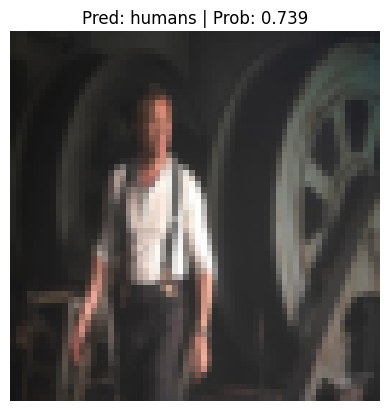

In [317]:
# Pred on our custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)


#Saving and loading a model

In [318]:
# 1. Create models directory
MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_TinyVGG_CustomDataset_TrainedModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_params = {
    "input_shape": 3,
    "hidden_units": 10,
    "output_shape": len(train_data_simple.classes)
}

model_state = {
    "state_dict": model.state_dict(),
    "params": model_params
}
torch.save(model_state, MODEL_SAVE_PATH)
print(f"Model and parameters saved to: {MODEL_SAVE_PATH}")

Model and parameters saved to: saved_models/01_TinyVGG_CustomDataset_TrainedModel.pth


In [319]:
model_state = torch.load(MODEL_SAVE_PATH)

model_params = model_state["params"]

loaded_model_1 = TinyVGG(input_shape=model_params["input_shape"],
                         hidden_units=model_params["hidden_units"],
                         output_shape=model_params["output_shape"])

loaded_model_1.load_state_dict(model_state["state_dict"])

loaded_model_1.to(device)
print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)
Model on device:
cpu


#Evaluate the loaded model

In [320]:
all_preds = []
all_labels = []

loaded_model_1.eval()
with torch.inference_mode():
    for X_batch, y_batch in test_dataloader_simple:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = loaded_model_1(X_batch)
        all_preds.append(y_pred)
        all_labels.append(y_batch)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels.cpu(), torch.argmax(all_preds, dim=1).cpu())
print(f"Accuracy of the loaded model on the test set: {accuracy:.4f}")

Accuracy of the loaded model on the test set: 0.8711
